# Predicting Buying Session - EDA

## Init

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns

In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
df = pd.read_csv('online_shoppers_intention.csv')

In [6]:
num_feats = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
             'BounceRates', 'ExitRates', 'PageValues']

In [7]:
cat_feats = ['Month', 'OperatingSystems', 'Browser', 'Region',
             'TrafficType', 'VisitorType', 'Weekend', 'Revenue']
df[cat_feats] = df[cat_feats].astype('object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  object 
 12  Browser                  12330 non-null  object 
 13  Region                   12330 non-null  object 
 14  TrafficType           

## Target

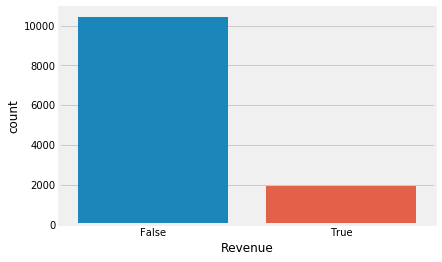

In [9]:
sns.countplot(df['Revenue'])

In [10]:
df['Revenue'].value_counts().apply(lambda x: str(round(x/df['Revenue'].value_counts().sum()*100, 2))+'%')

False    84.53%
True     15.47%
Name: Revenue, dtype: object

## Features

### Numerical

#### Distributions

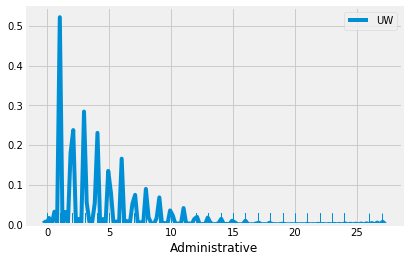

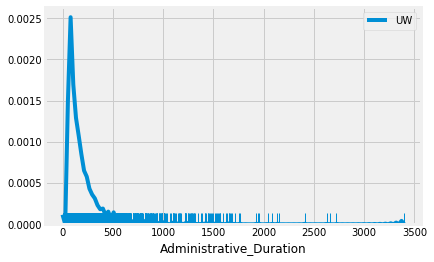

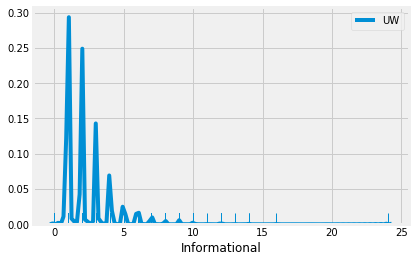

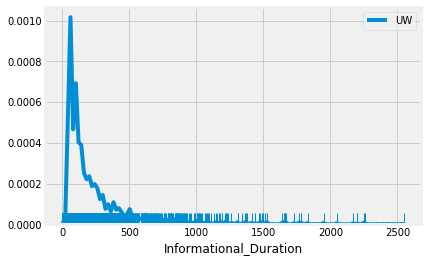

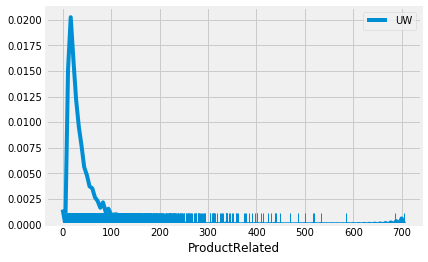

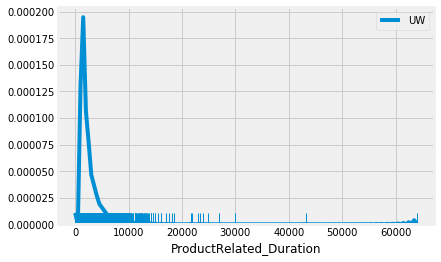

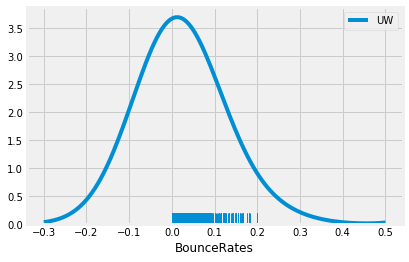

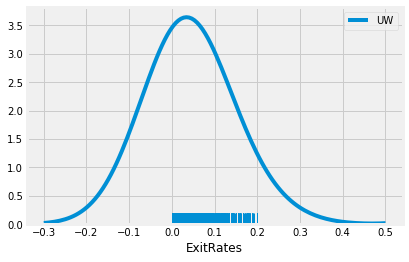

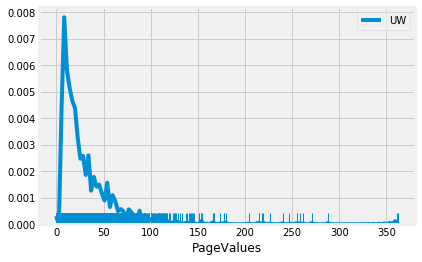

In [11]:
for column in num_feats:
    sns.distplot(df[column], rug=True, hist=False, label='UW', kde_kws={'bw':0.1})
    plt.show()

#### Correlations

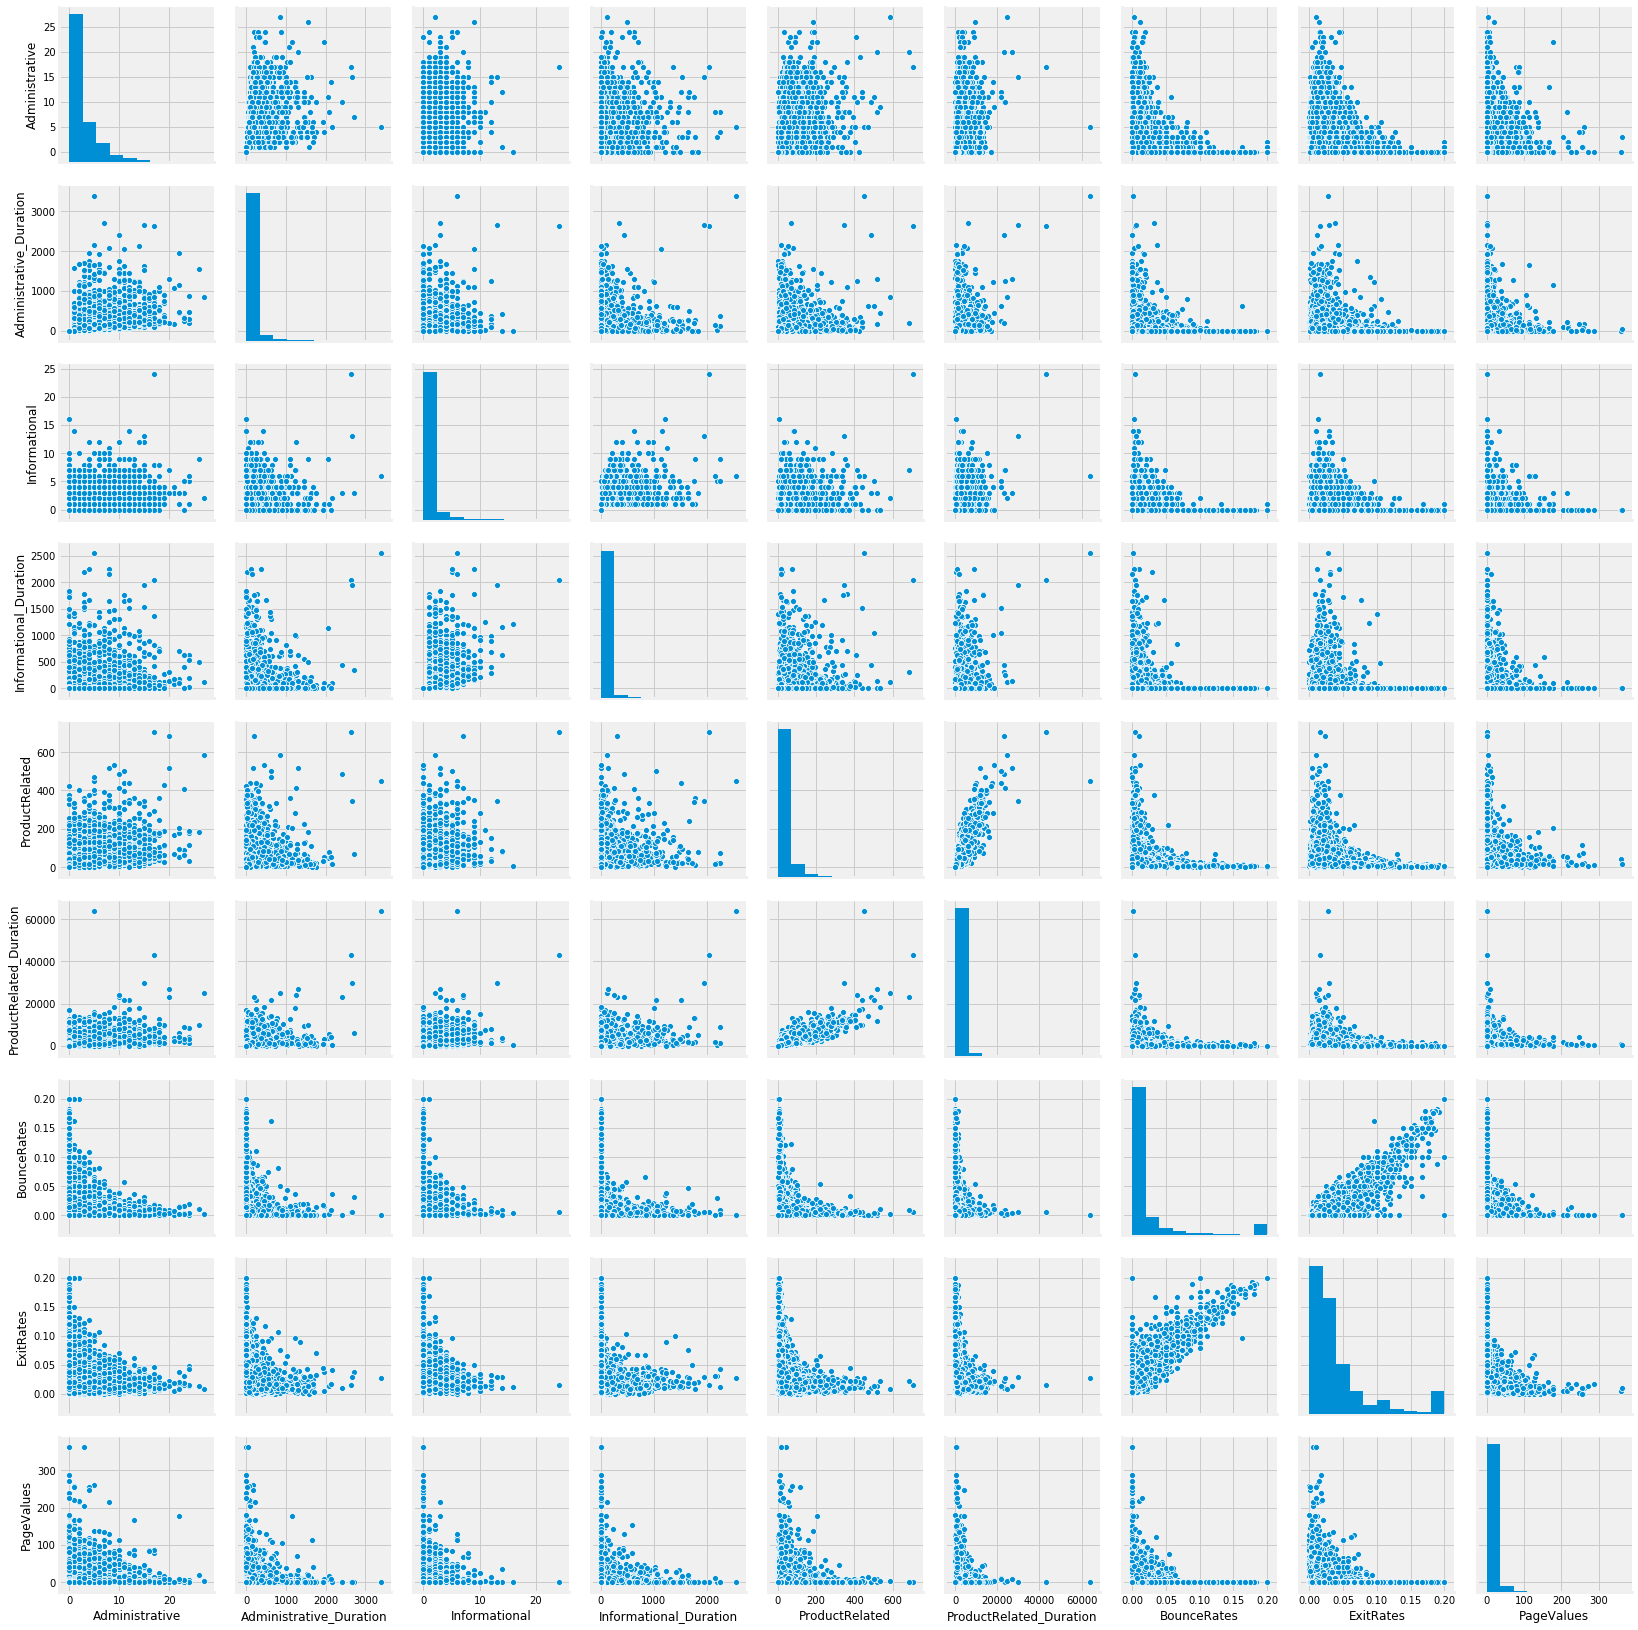

In [12]:
sns.pairplot(df[num_feats])

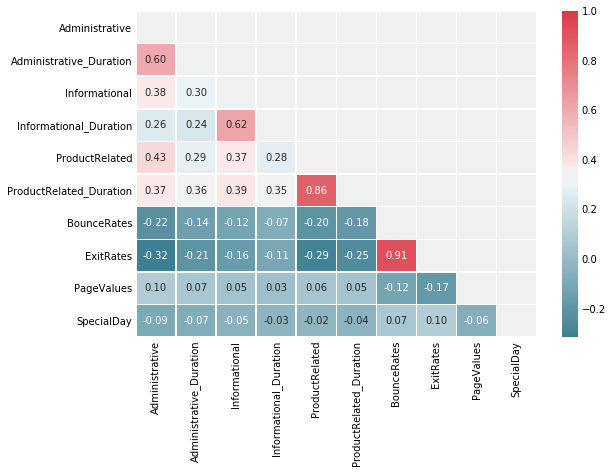

In [28]:
corr = df.corr('pearson')
fig, ax = plt.subplots(figsize=(8, 6))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

### Categorical

#### Distributions

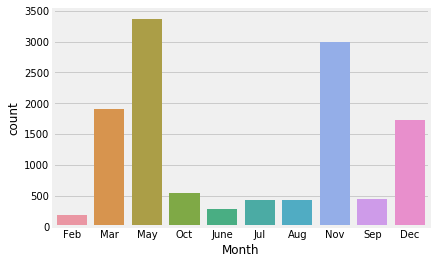

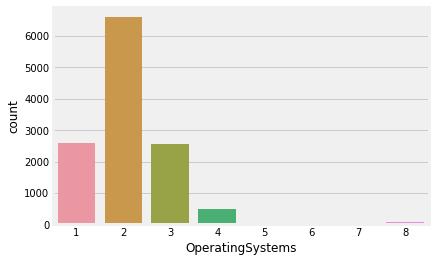

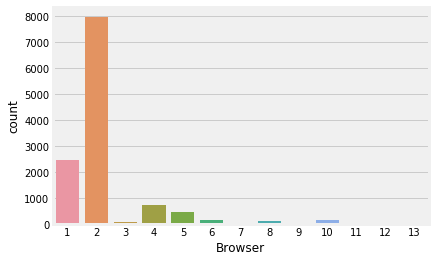

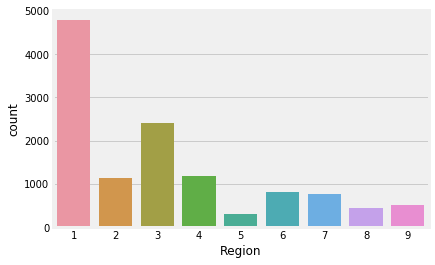

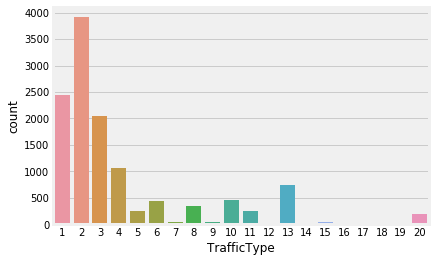

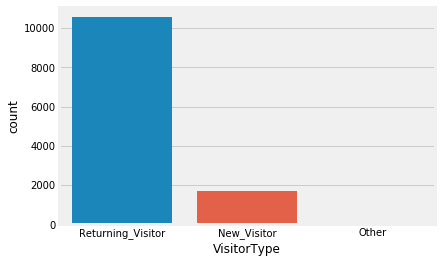

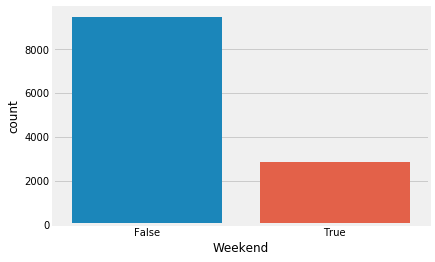

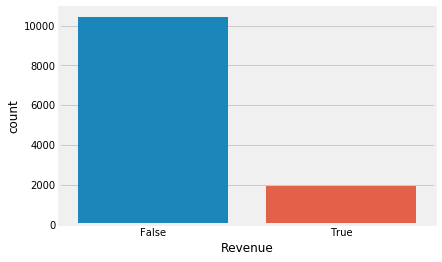

In [14]:
for feat in cat_feats:
    sns.countplot(df[feat])
    plt.show()

What is exactly VisitorType='Other'? Consider deleting these records, Google Analytics only has Returning/New Visitors<br>
To prevent overfitting, we can consider combining sparse classes @ OperatingSystems, Browser, TrafficType.

In [15]:
def composition(col):
    return df[col].value_counts().apply(lambda x: str(round(x/df[col].value_counts().sum()*100, 2))+'%')

In [16]:
for feat in cat_feats:
    print(feat)
    composition(feat)

Month
OperatingSystems
Browser
Region
TrafficType
VisitorType
Weekend
Revenue


Administrative/Informational/ProductRelated pageview <--> its counterpart duration is HIGHLY correlated (60% - 86%)<br>
To reduce features + solve autocorrelation, consider creating interaction variable as below?
* Administrative = Administrative * Administrative_Duration
* Informational = Informational * Administrative_Duration
* ProductRelated = ProductRelated * Administrative_Duration
which is a sum of information contained in both variable.<br>


<br>
Also note: ExitRates <--> BounceRates (90%!)


<br>
It's natural for PageValues to be correlated to Revenue (49%), since visitor will visit billing pages before purchase

## Freeform

### Numerical

In [17]:
df.groupby('Revenue').agg('mean')[num_feats]

Administrative  Administrative_Duration  Informational  \
Revenue                                                           
False          2.117732                73.740111       0.451833   
True           3.393606               119.483244       0.786164   

         Informational_Duration  ProductRelated  ProductRelated_Duration  \
Revenue                                                                    
False                 30.236237       28.714642              1069.987809   
True                  57.611427       48.210168              1876.209615   

         BounceRates  ExitRates  PageValues  
Revenue                                      
False       0.025317   0.047378    1.975998  
True        0.005117   0.019555   27.264518

In [18]:
fig = px.scatter(df, x="Administrative_Duration", y="Administrative", color="Revenue")
fig.show()

fig = px.scatter(df, x="Informational_Duration", y="Informational", color="Revenue")
fig.show()

fig = px.scatter(df, x="ProductRelated_Duration", y="ProductRelated", color="Revenue")
fig.show()

fig = px.scatter(df, x="BounceRates", y="ExitRates", color="Revenue")
fig.show()

### TrafficType

In [19]:
df.groupby('TrafficType').agg('mean')[[
    'BounceRates', 'ExitRates', 'PageValues']].sort_values(by='BounceRates', ascending=False)

BounceRates  ExitRates  PageValues
TrafficType                                    
15              0.069922   0.089755    0.036468
17              0.050000   0.075000    0.000000
13              0.048708   0.070333    2.354585
3               0.033314   0.057117    3.276033
18              0.033128   0.053055    0.000000
1               0.032346   0.055708    3.455074
20              0.027534   0.047548   15.128326
9               0.026341   0.045366    3.818558
19              0.025751   0.049762    3.497520
11              0.022210   0.043753    5.068642
6               0.022103   0.045412    5.076244
10              0.016633   0.037910    6.208230
4               0.016261   0.036155    7.043113
8               0.011499   0.029639   10.302436
5               0.009451   0.029679    7.712489
2               0.008455   0.026391    8.304366
7               0.007822   0.024818   13.567345
14              0.002434   0.024006    4.936097
12              0.000000   0.066667    0.000000
16              0.000000   0.017998    0.000000

In [20]:
traffic_conversion = pd.crosstab(df.TrafficType, 
                            df.Revenue,
                            margins=True, 
                            margins_name="Total"
)
traffic_conversion['ConversionRate (%)'] = round(traffic_conversion[True]/traffic_conversion['Total']*100, 2)
traffic_conversion.sort_values(by='ConversionRate (%)', ascending=False)

Revenue      False  True  Total  ConversionRate (%)
TrafficType                                        
16               2     1      3               33.33
7               28    12     40               30.00
8              248    95    343               27.70
20             148    50    198               25.25
2             3066   847   3913               21.65
5              204    56    260               21.54
10             360    90    450               20.00
11             200    47    247               19.03
Total        10422  1908  12330               15.47
4              904   165   1069               15.43
14              11     2     13               15.38
6              391    53    444               11.94
1             2189   262   2451               10.69
9               38     4     42                9.52
3             1872   180   2052                8.77
19              16     1     17                5.88
13             695    43    738                5.83
12               1     0      1                0.00
15              38     0     38                0.00
17               1     0      1                0.00
18              10     0     10                0.00

In [21]:
pd.crosstab(df.TrafficType, 
            df.Revenue,
            values=df.PageValues,
            aggfunc='median'
#             margins=True, 
#             margins_name="Total"
           ).round(2).sort_values(by=True, ascending=False)

Revenue      False  True 
TrafficType              
19             0.0  56.36
7              0.0  39.31
20             0.0  37.52
9              0.0  30.25
14             0.0  27.77
4              0.0  24.29
6              0.0  20.97
5              0.0  20.47
2              0.0  17.22
8              0.0  17.15
13             0.0  16.05
3              0.0  14.80
10             0.0  12.46
1              0.0  11.68
11             0.0  10.22
16             0.0   0.00
12             0.0    NaN
15             0.0    NaN
17             0.0    NaN
18             0.0    NaN

In [22]:
rev_true_labels = [i for i in df[df['Revenue']==True]['TrafficType'].value_counts().sort_index().index]
rev_true_values = [i for i in df[df['Revenue']==True]['TrafficType'].value_counts().sort_index().values]
rev_false_labels = [i for i in df[df['Revenue']==False]['TrafficType'].value_counts().sort_index().index]
rev_false_values = [i for i in df[df['Revenue']==False]['TrafficType'].value_counts().sort_index().values]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Purchased', 'Did not purchase']
                   )
fig.add_trace(go.Pie(labels=rev_true_labels, 
                     values=rev_true_values, 
                     name="1", 
                     scalegroup='one',
                    ),
              1, 1
             )
fig.add_trace(go.Pie(labels=rev_false_labels, 
                     values=rev_false_values, 
                     name="0", 
                     scalegroup='one'),
              1, 2
             )

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="From which channels do visitors come from?",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='', x=0.18, y=0.5, font_size=10, showarrow=False),
                 dict(text='', x=0.82, y=0.5, font_size=10, showarrow=False)])
fig.show()

### Month

In [23]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=months,
    y=[i for i in df[df['Revenue']==True]['Month'].value_counts().reindex(months).values],
    name='Purchased',
    marker_color='mediumvioletred'
))
fig.add_trace(go.Bar(
    x=months,
    y=[i for i in df[df['Revenue']==False]['Month'].value_counts().reindex(months).values],
    name='Did not purchase',
    marker_color='slategrey'
))

# # Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45,
                 title='Number of Transactions by Month',
                   xaxis_title='Month',
                   yaxis_title='Number of Transactions')
fig.show()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=months, 
                         y=[i for i in df[df['Revenue']==True]['Month'].value_counts().reindex(months).values], 
                         name = 'Purchased',
                         line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=months, 
                         y=[i for i in df[df['Revenue']==False]['Month'].value_counts().reindex(months).values], 
                         name='Did not purchase',
                         line=dict(color='firebrick', width=4) # dash options include 'dash', 'dot', and 'dashdot'
))

# Edit the layout
fig.update_layout(title='Line Chart',
                   xaxis_title='Month',
                   yaxis_title='Number of Transactions')


fig.show()

### Region

In [24]:
regions=df["Region"].value_counts()

# pie plot
fig = px.pie(regions,
             values=regions.values,
             names=regions.index,
             title="From what regions do visitors come from?",
             color_discrete_sequence=px.colors.diverging.curl)
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

### VisitorType

In [25]:
visitors=df['VisitorType'].value_counts()

# pie plot
fig = px.pie(visitors,
             values=visitors.values,
             names=visitors.index,
             title="What's the composition of our visitors?",
             color_discrete_sequence=px.colors.diverging.Portland)
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

visitors=[i for i in df['VisitorType'].unique()]

fig = go.Figure(data=[
    go.Bar(name='Purchased', 
           x=visitors, 
           y=[i for i in df[df['Revenue']==True]['VisitorType'].value_counts().reindex(visitors).values], 
           marker_color='mediumvioletred'
          ),
    go.Bar(name='Did not purchase', 
           x=visitors, 
           y=[i for i in df[df['Revenue']==False]['VisitorType'].value_counts().reindex(visitors).values], 
           marker_color='slategrey'),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

# visitors=[i for i in df['VisitorType'].unique()]

# fig = go.Figure()
# fig.add_trace(go.Bar(
#     y=visitors,
#     x=[i for i in df[df['Revenue']==True]['VisitorType'].value_counts().reindex(visitors).values],
#     name='Purchased',
#     orientation='h'
# ))
# fig.add_trace(go.Bar(
#     y=visitors,
#     x=[i for i in df[df['Revenue']==False]['VisitorType'].value_counts().reindex(visitors).values],
#     name='Did not purchase',
#     orientation='h'
# ))

# fig.update_layout(barmode='stack')
# fig.show()

### Weekend

In [26]:
weekend=[i for i in df['Weekend'].unique()]

fig = go.Figure(data=[
    go.Bar(name='Purchased', 
           x=weekend, 
           y=[i for i in df[df['Revenue']==True]['Weekend'].value_counts().reindex(weekend).values], 
           marker_color='mediumvioletred'
          ),
    go.Bar(name='Did not purchase', 
           x=weekend, 
           y=[i for i in df[df['Revenue']==False]['Weekend'].value_counts().reindex(weekend).values], 
           marker_color='slategrey'),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()